In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
with open('/content/drive/MyDrive/dna_data.txt', 'r', encoding='utf-8') as file:
  dataset = file.readlines()
  dataset = "".join(line.strip() for line in dataset if line.strip())
  dataset = dataset.upper()
print(len(dataset)/1e6, 'million words')

4.699672 million words


In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [4]:
class ModelConfig:
  d_model: int= 128
  in_dim: int= 4
  n_embed: int=512
  beta: float=0.25
  n_heads: int= 8
  n_layers: int= 8

In [5]:
class encoder(nn.Module):
  def __init__(self, _in, d_model, n_layers, n_heads):
    super().__init__()
    self.embed = nn.Linear(_in, d_model)
    self.encoder = nn.TransformerEncoder(
      nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads),
      num_layers=n_layers)

  def forward(self, x):
    x = self.embed(x)
    x = x.permute(1, 0, 2)  # (L, B, d_model)
    z_e = self.encoder(x) # Transformer encoding
    return z_e.permute(1, 0, 2) # Back to (B, L, 4)

class decoder(nn.Module):
  def __init__(self, d_model, _out, n_layers, n_heads):
    super().__init__()
    self.decoder = nn.TransformerDecoder(
      nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads),
      num_layers=n_layers
    )
    self.fc_out = nn.Linear(d_model, _out)  # Output logits (4 classes)

  def forward(self, z_q):
    z_q = z_q.permute(1, 0, 2)  # (L, B, d_model)
    x_recon = self.decoder(z_q, z_q)  # Transformer decoding
    x_recon = self.fc_out(x_recon.permute(1, 0, 2))  # Back to (B, L, 4)
    return x_recon

class Quantizer(nn.Module):
  def __init__(self, n_embed, d_model, beta):
    super().__init__()
    self.n_embed, self.d_model, self.beta = n_embed, d_model, beta
    self.embeddings = nn.Embedding(n_embed, d_model)
    self.embeddings.weight.data.uniform_(-1.0 / n_embed, 1.0 / n_embed)

  def forward(self, z_e):
    # z_e_flat = z_e.view(-1, self.d_model)
    z_e_flat = z_e.reshape(-1, self.d_model)
    distances = torch.cdist(z_e_flat, self.embeddings.weight)
    encoding_indices = torch.argmin(distances, dim=1)
    z_q = self.embeddings(encoding_indices).view(z_e.shape)
    loss = self.beta * torch.mean((z_q.detach() - z_e) ** 2) + torch.mean((z_e.detach() - z_q) ** 2)

    z_q = z_e + (z_q - z_e).detach()
    return z_q, loss, encoding_indices.view(z_e.shape[:-1])

class DNA_VQVAE(nn.Module):
  def __init__(self, args: ModelConfig):
    super().__init__()
    self.encoder = encoder(args.in_dim, args.d_model, args.n_layers, args.n_heads)
    self.vq_layer = Quantizer(args.n_embed, args.d_model, args.beta)
    self.decoder = decoder(args.d_model, args.in_dim, args.n_layers, args.n_heads)

  def forward(self, x):
    z_e = self.encoder(x)
    z_q, vq_loss, indices = self.vq_layer(z_e)
    x_recon = self.decoder(z_q)
    return x_recon, vq_loss, indices

In [7]:
import os
DNA_VOCAB = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
INDEX_TO_DNA = {v: k for k, v in DNA_VOCAB.items()}  # Reverse mapping

class Dataset:
  def __init__(self, file_path, ratio:float=0.25):
    """
      Initialize the Dataset
      Args:
        file_path (str): Path to the DNA data file
        test_split (float): Fraction of data to use for testing (default 0.2)"""
    self.file_path = file_path
    self.test_split = ratio
    self.data = ""
    self.train_data = ""
    self.val_data = ""
    self.load_and_format_data()
    self.train_test_split()

  def load_and_format_data(self):
    """
      Loads the file and formats the data:
        - Reads all lines
        - Strips whitespace and removes newline characters
        - Joins all lines into a single continuous string
        - Converts the string to uppercase"""
    if not os.path.isfile(self.file_path):
      raise FileNotFoundError(f"{self.file_path} does not exist.")

    with open(self.file_path, "r", encoding="utf-8") as f:
      raw_lines = f.readlines()

    # Remove empty lines, strip whitespace, and join into one continuous string.
    formatted_data = "".join(line.strip() for line in raw_lines if line.strip())
    self.data = formatted_data.upper()

  @staticmethod
  def dna_to_onehot(seq):
    """
      Converts a DNA sequence (string) into a one-hot encoded tensor
      Only characters 'A', 'C', 'G', 'T' are considered
      Args:
        seq (str): DNA sequence
      Returns:
        Tensor of shape (L, 4) where L is the length of the sequence"""
    DNA_VOCAB = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    # convert each character to an index
    indices = [DNA_VOCAB[char] for char in seq if char in DNA_VOCAB]
    onehot = F.one_hot(torch.tensor(indices), num_classes=4).float()
    return onehot

  def get_batch(self, split, batch_size, block_size, device="cpu"):
    """
      Samples a random batch of subsequences from the train or validation data
      Args:
        split (str): "train" or "val"
        batch_size (int): Number of samples in the batch
        block_size (int): Length of each subsequence
        device (str): Device to move the tensors to (e.g. "cpu" or "cuda")
      Returns:
        Tuple of tensors (x, y) where x is the input batch and y is the target batch
        The target is the input sequence shifted by one character"""
    data = self.train_data if split == "train" else self.val_data
    if len(data) < block_size + 1:
      print(data[:3], len(data), block_size)
      raise ValueError("Data length is less than block size.")
    # randomly choose starting indices
    ix = torch.randint(0, len(data) - block_size, (batch_size,))
    x = torch.stack([self.dna_to_onehot(data[i:i+block_size]) for i in ix])
    y = torch.stack([self.dna_to_onehot(data[i+1:i+block_size+1]) for i in ix])
    return x.to(device), y.to(device)

  def train_test_split(self):
    """
      Splits the formatted data into training and testing sets
      Returns:
        A tuple (train_data, test_data) containing the split strings"""
    if not self.data:
      raise ValueError("Data is not loaded. Please check the file content.")

    split_idx = int(len(self.data) * (1 - self.test_split))
    self.train_data = self.data[:split_idx]
    self.test_data = self.data[split_idx:]
    return self.train_data, self.test_data

  def get_full_data(self):
    """
      Returns the full formatted DNA string"""
    return self.data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if idx < 0 or idx >= len(self.data):
      raise IndexError("Index out of range.")
    return self.data[idx]

In [6]:
DNA_VOCAB = {"A": 0, "T": 1, "C": 2, "G": 3}
INDEX_TO_DNA = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DNA_VQVAE(ModelConfig).to(device)

class tokenizer:
  def __init__(self):
    self.vocab = DNA_VOCAB
    self.ids_to_dna = INDEX_TO_DNA
    self.device = device

  def __str__(self):
    return f"\t/Biosaic VQ-VAE tokenizer v1.0.0/\t"

  def dna_to_onehot(self, seq):
    seq_idx = [DNA_VOCAB[char] for char in seq]
    one_hot = F.one_hot(torch.tensor(seq_idx), num_classes=4)
    return one_hot.float()

  def onehot_to_dna(self, logits):
    decoded_out = torch.argmax(logits, dim=-1)
    decoded = ''.join(self.ids_to_dna[idx.item()] for idx in decoded_out.squeeze(0))
    return decoded

  def encode(self, seq: str):
    one_hot_seq = self.dna_to_onehot(seq).unsqueeze(0).to(device)
    _, _, tokens = model(one_hot_seq)
    return tokens.sequeeze(0).cpu().numpy()

  def decode(self, tokens: list):
    tokens = torch.tensor(tokens, dtype=torch.long).to(device)
    z_q = model.vq_layer.embeddings(tokens)

    with torch.no_grad():
      logits = model.decoder(z_q)
    decoded = self.onehot_to_dna(logits)
    return decoded

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [7]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
_model = DNA_VQVAE(ModelConfig).to("cpu")
n_param = sum(p.numel() for p in _model.parameters())/1e6
print(f"{n_param:.2f} million")
optimizer = torch.optim.Adam(_model.parameters(), lr=1e-5)

# train-test split
file_path = "/content/drive/MyDrive/dna_data.txt"
data = Dataset(file_path, ratio=0.2)
train_data, val_data = data.train_test_split()

10.09 million


NameError: name 'Dataset' is not defined

In [8]:
DNA_VOCAB = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
INDEX_TO_DNA = {v: k for k, v in DNA_VOCAB.items()}  # Reverse mapping

class Dataset:
  def __init__(self, path:str):
    self.path = path

  def load_simple(self):
    with open(self.path, "r", encoding="utf-8") as f:
      lines = [line.strip() for line in f.readlines() if line.strip()]  # removing empty lines & strip whitespace
    merged_sequence = "".join(lines)  # joining all lines into a single sequence
    return merged_sequence

  def load_encoded(self, seq=None):
    if seq:
      loaded_sequences = seq
    else:
      loaded_sequences = self.load_simple()
    seq_idx = [DNA_VOCAB[char] for char in loaded_sequences]
    return F.one_hot(torch.tensor(seq_idx, dtype=torch.long), num_classes=4) # shape (L, 4)

  def train_test_split(self, sequence:str=None, ratio:float=0.8):
    sequence = self.load_encoded(seq=sequence) if sequence else self.load_encoded()
    split_size = int(0.8 * len(sequence))

    train_data = sequence[:split_size]
    test_data = sequence[split_size:]
    return train_data, test_data

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
_model = DNA_VQVAE(ModelConfig).to("cpu")
n_param = sum(p.numel() for p in _model.parameters())/1e6
print(f"{n_param:.2f} million")
optimizer = torch.optim.Adam(_model.parameters(), lr=1e-5)

# train-test split
file_path = "/content/drive/MyDrive/dna_data.txt"
data = Dataset(file_path)
train_data, val_data = data.train_test_split(ratio=0.85)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


10.09 million


In [9]:
print(train_data[:5])

tensor([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1]])


In [10]:
batch_size = 8
block_size = 64
epochs = 2000
eval_interval = 100
eval_iters = 50
learning_rate = 1e-5
loss_history = []

def get_batch(split):
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data) - block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in ix]).float()  # Convert to float
  y = torch.stack([data[i+1:i+block_size+1] for i in ix]).float()  # Convert to float
  return x.to("cpu"), y.to("cpu")

@torch.no_grad()
def estimate_loss():
  out = {}
  _model.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y = get_batch(split)
      x_recon, vq_loss, _ = _model(X)
      recon_loss = F.cross_entropy(x_recon.view(-1, 4), Y.view(-1, 4))
      losses[k] = (recon_loss + vq_loss).item()
    out[split] = losses.mean()
  _model.train()
  return out

for epoch in range(epochs):
  xb, yb = get_batch('train')

  optimizer.zero_grad()
  x_recon, vq_loss, _ = _model(xb)
  recon_loss = F.cross_entropy(x_recon.view(-1, 4), yb.view(-1, 4))
  loss = recon_loss + vq_loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch + 1) % eval_interval == 0:
    losses = estimate_loss()
    print(f"Epoch {epoch+1}: Train Loss = {losses['train']:.4f}, Val Loss = {losses['val']:.4f}")
    loss_history.append((epoch + 1, losses['train'], losses['val']))

Epoch 100: Train Loss = 2.6277, Val Loss = 2.6281
Epoch 200: Train Loss = 2.6132, Val Loss = 2.6128
Epoch 300: Train Loss = 2.6086, Val Loss = 2.6093
Epoch 400: Train Loss = 2.6082, Val Loss = 2.6040
Epoch 500: Train Loss = 2.6060, Val Loss = 2.6033
Epoch 600: Train Loss = 2.6031, Val Loss = 2.6020
Epoch 700: Train Loss = 2.6017, Val Loss = 2.6028
Epoch 800: Train Loss = 2.6010, Val Loss = 2.6005
Epoch 900: Train Loss = 2.6003, Val Loss = 2.5997
Epoch 1000: Train Loss = 2.6006, Val Loss = 2.5973
Epoch 1100: Train Loss = 2.6002, Val Loss = 2.5973
Epoch 1200: Train Loss = 2.5994, Val Loss = 2.5960
Epoch 1300: Train Loss = 2.5981, Val Loss = 2.5963
Epoch 1400: Train Loss = 2.5946, Val Loss = 2.5944
Epoch 1500: Train Loss = 2.5962, Val Loss = 2.5929
Epoch 1600: Train Loss = 2.5943, Val Loss = 2.5956
Epoch 1700: Train Loss = 2.5934, Val Loss = 2.5947
Epoch 1800: Train Loss = 2.5919, Val Loss = 2.5911
Epoch 1900: Train Loss = 2.5933, Val Loss = 2.5911
Epoch 2000: Train Loss = 2.5925, Val Los

In [ ]:
batch_size = 8
block_size = 16
epochs = 5000
eval_interval = 100
eval_iters = 75
learning_rate = 2e-5
loss_history = []

@torch.no_grad()
def estimate_loss():
  out = {}
  _model.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y = data.get_batch(split, batch_size, block_size, "cpu")
      x_recon, vq_loss, _ = _model(X)
      recon_loss = F.cross_entropy(x_recon.view(-1, 4), Y.view(-1, 4))
      losses[k] = (recon_loss + vq_loss).item()
    out[split] = losses.mean()
  _model.train()
  return out

for epoch in range(epochs):
  xb, yb = data.get_batch('train', batch_size, block_size, "cpu")

  optimizer.zero_grad()
  x_recon, vq_loss, _ = _model(xb)
  recon_loss = F.cross_entropy(x_recon.view(-1, 4), yb.view(-1, 4))
  loss = recon_loss + vq_loss
  loss.backward()
  optimizer.step()

  if (epoch + 1) % eval_interval == 0 or epoch == 0:
    losses = estimate_loss()
    print(f"Epoch {epoch+1}: Train Loss = {losses['train']:.4f}, Val Loss = {losses['val']:.4f}")
    loss_history.append((epoch + 1, losses['train'], losses['val']))

ValueError: Data length is less than block size.

In [11]:
n_param = sum(p.numel() for p in model.parameters())/1e6
print(f"{n_param:.2f} million")
torch.save(model.state_dict(), f'biosaic_{n_param:.0f}m.pth')

10.09 million


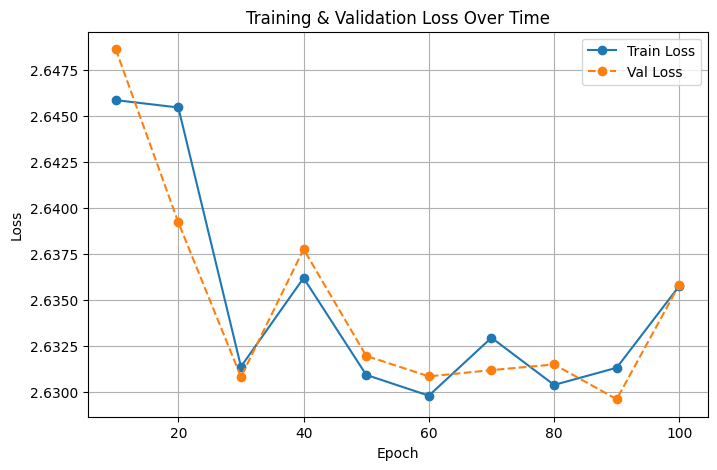

In [ ]:
import matplotlib.pyplot as plt

epochs_logged, train_losses, val_losses = zip(*loss_history)
plt.figure(figsize=(8, 5))
plt.plot(epochs_logged, train_losses, label="Train Loss", marker='o', linestyle='-')
plt.plot(epochs_logged, val_losses, label="Val Loss", marker='o', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss Over Time")
plt.grid(True)
plt.show()